In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class ScaledWindowedVariance:
    """
    This implementation is based on the paper:
    "Evaluating scaled windowed variance methods for estimating
    the Hurst coefficient of time series" from Physica A. 1997 July 15; 241(3-4): 606–626.
    """
    def __init__(self, data: pd.Series, 
                min_window: int = 2, 
                max_window: int = None, 
                custom_window_list: list = None):
        """
        ScaledWindowedVariance calculates the scaled windowed variance of a time series.
        It allows for different methods of calculation and can exclude certain values based on the method.

        Parameters:
        data (pd.Series): The time series data to analyze.
        min_window (int): The minimum window size for the rolling calculation.
        max_window (int): The maximum window size for the rolling calculation.
        custom_window_list (list): A custom list of window sizes to use instead of the default range.
        """

        self.data = data
        
        self.N = len(data)
        if self.N < 2:
            raise ValueError("Data must contain at least two points.")
        
        self.min_window = int(np.log2(min_window))
        self.max_window = int(np.floor(np.log2(self.N))) if max_window is None else int(np.log2(max_window))

        print(f"Data length: {self.N}, Min window: {min_window}, Max window: {self.max_window}")
        self.window_sizes = 2 ** np.arange(self.min_window, self.max_window + 1)
    
    def _manage_detrending(self, window):
        """Apply the appropriate detrending method."""
        if self.method == 'SD':
            return window
        elif self.method == 'LD':    
            return self._detrend_linear(window)
        elif self.method == 'BD':
            return self._detrend_bridge(window)

    def _detrend_linear(self, window):
        """Remove linear trend from window using regression."""
        x = np.arange(len(window))
        slope, intercept = np.polyfit(x, window, 1)
        trend = slope * x + intercept
        return window - trend

    def _detrend_bridge(self, window):
        """Remove bridge trend from window."""
        if len(window) < 2:
            return window
        x = np.arange(len(window))
        first, last = window[0], window[-1]
        trend = np.linspace(first, last, len(window))
        return window - trend
        
    def _find_exclusions_bounds(self):
        """Determine the exclusions based on the method."""

        if self.exclusions is False:
            return 0, 0
        
        lower_window_exclusion = {"SD": [0, 0], "LD": [1, 0], "BD": [1, 0]}

        exclusions_dict = {
            6: {"SD": [0, 2], "LD": [2, 0], "BD": [1, 0]},
            7: {"SD": [0, 3], "LD": [2, 1], "BD": [1, 0]},
            8: {"SD": [0, 3], "LD": [2, 2], "BD": [1, 0]},
            9: {"SD": [1, 4], "LD": [2, 2], "BD": [2, 2]},
            10: {"SD": [1, 4], "LD": [2, 2], "BD": [2, 3]},
            11: {"SD": [1, 5], "LD": [3, 4], "BD": [2, 4]},
            12: {"SD": [1, 5], "LD": [3, 5], "BD": [2, 4]},
            13: {"SD": [2, 6], "LD": [3, 5], "BD": [2, 5]},
            14: {"SD": [2, 7], "LD": [4, 5], "BD": [3, 6]},
            15: {"SD": [2, 7], "LD": [5, 5], "BD": [3, 7]},
            16: {"SD": [3, 7], "LD": [6, 5], "BD": [3, 7]},
            17: {"SD": [4, 7], "LD": [7, 5], "BD": [3, 7]},
        }

        if self.max_window in exclusions_dict:
            return exclusions_dict[self.max_window][self.method]
        elif self.max_window > max(exclusions_dict.keys()):
            return exclusions_dict[max(exclusions_dict.keys())][self.method]
        else:
            return lower_window_exclusion[self.method]
        
    def _create_exclusion_mask(self):
        lower_bound, upper_bound = self._find_exclusions_bounds()

        # Création du masque
        mask = np.zeros(len(self.window_sizes), dtype=bool)
        mask[lower_bound:len(self.window_sizes)-upper_bound] = True

        return mask


            
    # def estimate_hurst(self, method: str = 'SD', exclusions: bool = False, plot: bool = False):

    #     self.exclusions = exclusions
    #     self.method = method

    #     if method not in ['SD', 'LD', 'BD']:
    #         raise ValueError("Method must be one of 'SD', 'LD' or 'BD'.")
        
    #     mask = self._create_exclusion_mask()
        
    #     avg_sds = []            # Liste pour stocker l'écart type moyen pour chaque taille de fenêtre
    #     valid_window_sizes = [] # On ne retient que les tailles pour lesquelles la division est possible
        
    #     # Pour chaque taille de fenêtre n
    #     for n in self.window_sizes:
    #         num_windows = self.N // n  # Nombre de fenêtres non chevauchantes

    #         sds = [np.std(self._manage_detrending(self.data[i * n:(i + 1) * n]), ddof=0) for i in range(num_windows)]

    #         avg_sd = np.mean(sds)
    #         avg_sds.append(avg_sd)
    #         valid_window_sizes.append(n)
        
    #     valid_window_sizes = np.array(valid_window_sizes)
    #     avg_sds = np.array(avg_sds)

    #     x = np.log(valid_window_sizes)
    #     y = np.log(avg_sds)

    #     if exclusions:
    #         x = x[mask]
    #         y = y[mask]
    #         slope, intercept = np.polyfit(x, y, 1)
    #     else:
    #         slope, intercept = None, None

    #     slope_all, intercept_all = np.polyfit(x, y, 1)
    #     estimated_H = slope if slope is not None else slope_all

    #     if plot:
    #         import matplotlib.pyplot as plt

    #         plt.figure(figsize=(10, 6))

    #         # Plot non-excluded points in black
    #         plt.scatter(x[mask], y[mask], color='black', label='Non-excluded', zorder=3)

    #         # Plot excluded points in gray
    #         plt.scatter(x[~mask], y[~mask], color='gray', label='Excluded', zorder=2)

    #         # Plot the line for non-excluded points (solid line)
    #         if slope is not None and intercept is not None:
    #             plt.plot(x[mask], slope * x[mask] + intercept, 'k-', label='Fit (non-excluded)', zorder=4)

    #         # Plot the line for all points (dashed line)
    #         plt.plot(x, slope_all * x + intercept_all, 'k--', label='Fit (all)', zorder=1)

    #         plt.xlabel('log(Window Size)')
    #         plt.ylabel('log(Avg SD)')
    #         plt.title('Scaled Windowed Variance')
    #         plt.legend()
    #         plt.grid(True)
    #         plt.show()

    #     return estimated_H

    def estimate_hurst(self, method: str = 'SD', exclusions: bool = False, plot: bool = False):
        self.exclusions = exclusions
        self.method = method

        if method not in ['SD', 'LD', 'BD']:
            raise ValueError("Method must be one of 'SD', 'LD' or 'BD'.")

        # Calcul des tailles de fenêtres valides et des écarts types moyens
        avg_sds = []            # Liste pour stocker l'écart type moyen pour chaque taille de fenêtre
        valid_window_sizes = [] # On ne retient que les tailles pour lesquelles la division est possible

        for n in self.window_sizes:
            num_windows = self.N // n  # Nombre de fenêtres non chevauchantes
            if num_windows < 1:
                continue  # Ignorer les tailles de fenêtres trop grandes

            sds = [np.std(self._manage_detrending(self.data[i * n:(i + 1) * n]), ddof=0) for i in range(num_windows)]

            avg_sd = np.mean(sds)
            avg_sds.append(avg_sd)
            valid_window_sizes.append(n)

        valid_window_sizes = np.array(valid_window_sizes)
        avg_sds = np.array(avg_sds)

        # Génération du masque basé sur les tailles de fenêtres valides
        mask = np.zeros(len(valid_window_sizes), dtype=bool)
        if exclusions:
            lower_bound, upper_bound = self._find_exclusions_bounds()
            mask[lower_bound:len(valid_window_sizes) - upper_bound] = True
        else:
            mask[:] = True  # Pas d'exclusions, tout est inclus

        # Calcul des logarithmes
        x = np.log2(valid_window_sizes)
        y = np.log2(avg_sds)

        # Application du masque
        if exclusions:
            slope, intercept = np.polyfit(x[mask], y[mask], 1)
        else:
            slope, intercept = None, None

        slope_all, intercept_all = np.polyfit(x, y, 1)
        estimated_H = slope if slope is not None else slope_all

        if plot:
            fig, axs = plt.subplots(2, 1, figsize=(10, 12))

            axs[0].plot(self.data, color='black')
            axs[0].set_title('Original Time Series')
            axs[0].grid(True)

            axs[1].scatter(x[mask], y[mask], color='black', label='Non-excluded', zorder=3)
            axs[1].scatter(x[~mask], y[~mask], color='gray', label='Excluded', zorder=2)

            if slope is not None and intercept is not None:
                axs[1].plot(x[mask], slope * x[mask] + intercept, 'k-', label='Fit (non-excluded)', zorder=4)

            axs[1].plot(x, slope_all * x + intercept_all, 'k--', label='Fit (all)', zorder=1)

            axs[1].set_xlabel('log(Window Size)')
            axs[1].set_ylabel('log(Avg SD)')
            axs[1].set_title('Scaled Windowed Variance')
            axs[1].legend()
            axs[1].grid(True)

            plt.tight_layout()
            plt.show()

        return slope, slope_all

Data length: 1024, Min window: 2, Max window: 10


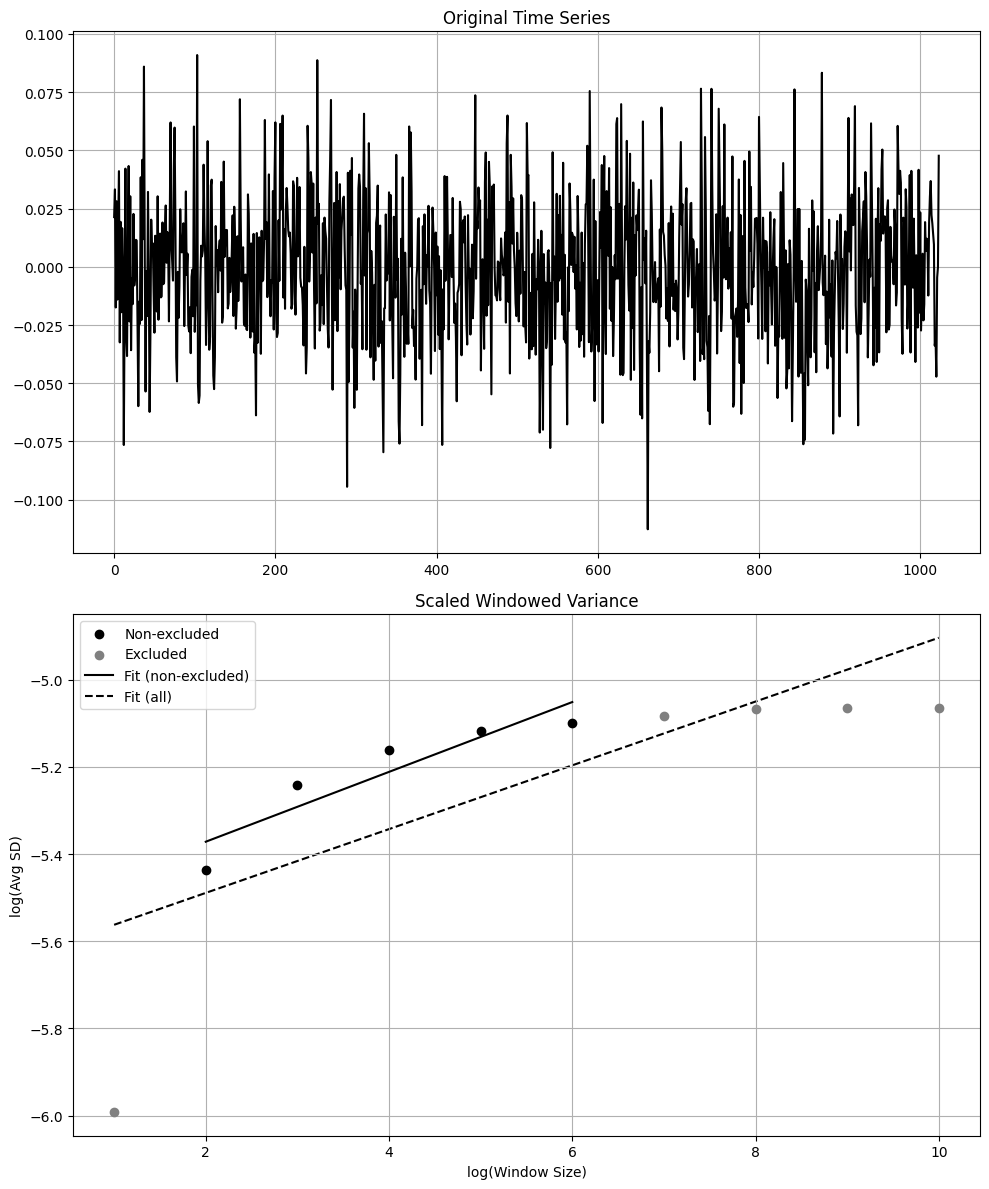

Estimated Hurst exponent: 0.08012973843179802
Estimated Hurst exponent (all): 0.07318755545671256
0.6166194439278195


In [108]:
import sys
sys.path.append('..')
from src.utils import get_config, get_data
from fbm import FBM
from src.ext.HurstIndexSolver import HurstIndexSolver


config = get_config()

# Chargement des données
ftse100 = get_data('ftse100')

N = 1024
H = 0.5

data_type = "fGn" # or "fBm" or signal

f = FBM(N, H)

if data_type == "fGn":
    # Generate a fGn realization
    signal = f.fgn()
elif data_type == "fBm":
    # Generate a fBm realization
    signal = f.fbm()
elif data_type == "signal":
    signal = ftse100.iloc[:N].values

HIS = HurstIndexSolver()
SWV = ScaledWindowedVariance(signal)
slope, slope_all = SWV.estimate_hurst(method='SD', exclusions=True, plot=True)
print(f"Estimated Hurst exponent: {slope}")
print(f"Estimated Hurst exponent (all): {slope_all}")

hurst_his = HIS.EstHurstAggregateVariance(signal, minimal=10)

print(hurst_his)